In [7]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.utils.mem import *
from fastprogress import *
from fastai.utils.mod_display import progress_disabled_ctx

from bayes_opt import BayesianOptimization

from pathlib import Path
from torchvision.models import mobilenet_v2

In [8]:
path = Path("./dataset/training_cleaned_test_set")

In [9]:
tfms =  get_transforms(max_rotate=60, max_zoom = 1.35, p_lighting=.7, max_warp=.25, xtra_tfms=[
])
data = (ImageList.from_folder(path.absolute(), ignore_empty=True)
        #.split_by_rand_pct(seed=7356)
        .split_by_folder()
        .label_from_folder()
        .transform(tfms, size=224)
        .databunch(bs=64+32)
        .normalize(imagenet_stats))  

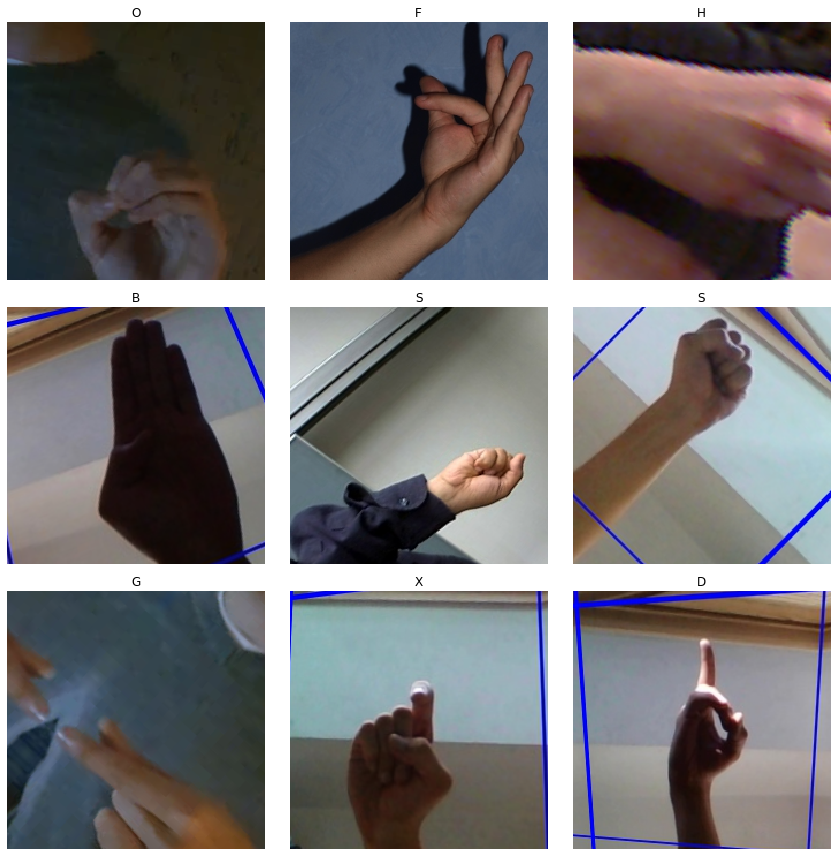

In [10]:
data.show_batch(3)

In [11]:
def fit_with(lr, wd):
    t_acc = partial(top_k_accuracy, k=3)

    early_stop = partial(EarlyStoppingCallback, monitor='top_k_accuracy', min_delta=0.01, patience=3)

    learner = cnn_learner(data, models.resnet18, metrics=[t_acc], model_dir=Path("./model").absolute(), callback_fns=[early_stop]).mixup()
    
    with progress_disabled_ctx(learner) as learner:
        learner.fit_one_cycle(15, max_lr=lr, wd=wd,  )
    
    # save, print, and return the model's overall accuracy
    top_acc = float(learner.validate(learner.data.valid_dl)[1])

    # Small change to the standard, we are only returning accuracy

    return top_acc

In [12]:
pbounds = {"lr": (1e-5, 1e-2), "wd": (4e-4, 0.4),}

optimizer = BayesianOptimization( 
    f = fit_with, # use our custom fit function    
    pbounds=pbounds, # use our limits
    verbose = 2, # 1 prints a maximum only when it is observed, 0 is completely silent
    random_state=1)

In [13]:
optimizer.maximize()

|   iter    |  target   |    lr     |    wd     |
-------------------------------------------------


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to C:\Users\Jonatan/.cache\torch\checkpoints\resnet18-5c106cde.pth



Epoch 9: early stopping


|  1        |  0.7452   |  0.004176 |  0.2882   |


KeyboardInterrupt: 

In [14]:
print(optimizer.max)

{'target': 0.7451963424682617, 'params': {'lr': 0.004176049826978714, 'wd': 0.2882416675794864}}


In [16]:
def fit_with_large(lr, wd):
    t_acc = partial(top_k_accuracy, k=3)

    early_stop = partial(EarlyStoppingCallback, monitor='top_k_accuracy', min_delta=0.001, patience=10)
    
    learner = cnn_learner(data, models.resnet18, metrics=[accuracy, t_acc], model_dir=Path("./model").absolute(), callback_fns=[early_stop]).mixup()
    
    learner.fit_one_cycle(50, max_lr=lr, wd=wd,  callbacks=[SaveModelCallback(learner, every='epoch', monitor='top_k_accuracy')])
    return learner

In [ ]:
learner = fit_with_large(**optimizer.max["params"])

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,3.799767,3.250882,0.111947,0.249791,00:52
1,3.187489,2.759697,0.217210,0.430242,00:51
2,2.653584,2.374256,0.311612,0.563910,00:55
3,2.313471,2.053853,0.405180,0.634921,00:57


[('Z', 'G', 52),
 ('I', 'Y', 37),
 ('F', 'W', 34),
 ('O', 'E', 31),
 ('J', 'Z', 24),
 ('J', 'Y', 17),
 ('N', 'T', 16),
 ('G', 'P', 15),
 ('P', 'K', 14),
 ('M', 'E', 13),
 ('C', 'S', 10),
 ('D', 'V', 10),
 ('G', 'Q', 9),
 ('T', 'N', 9),
 ('P', 'I', 7),
 ('P', 'R', 7),
 ('R', 'U', 7),
 ('N', 'S', 6),
 ('O', 'C', 6),
 ('P', 'Z', 6),
 ('Q', 'P', 6),
 ('C', 'B', 5),
 ('D', 'R', 5),
 ('D', 'Z', 5),
 ('J', 'space', 5)]

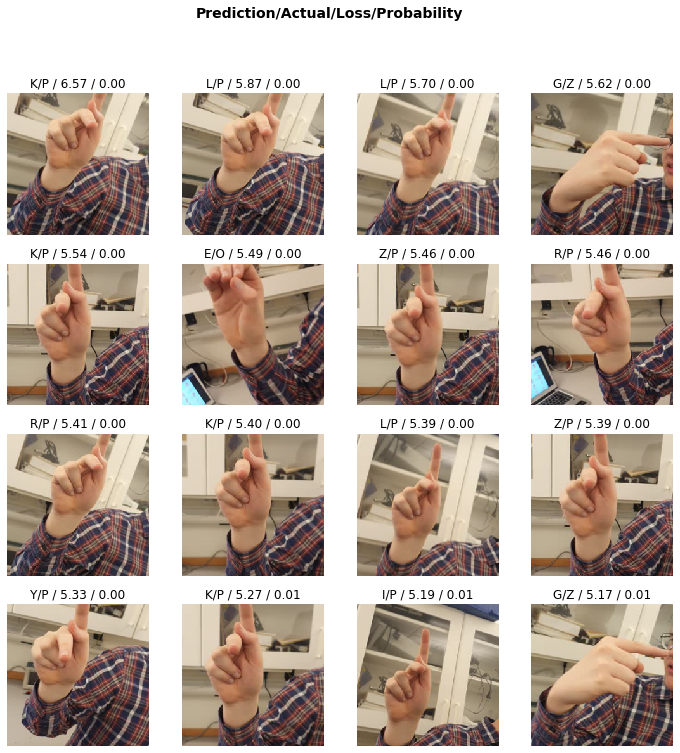

In [35]:
interpreter = ClassificationInterpretation.from_learner(learner)
interpreter.plot_top_losses(16, figsize=(12, 12))
interpreter.most_confused(min_val=5)

epoch,train_loss,valid_loss,top_k_accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


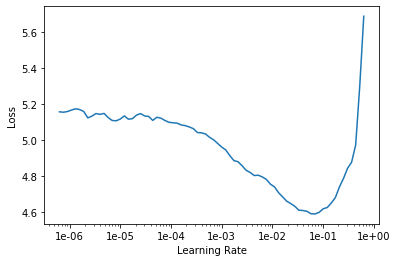

In [14]:
learner.lr_find()
learner.recorder.plot()

In [15]:
lr = 1e-3

In [16]:
learner.fit_one_cycle(25, max_lr=slice(lr, lr * 1e1))
#learner.recorder.plot_lr()

epoch,train_loss,valid_loss,top_k_accuracy,time
0,2.948455,2.487515,0.560568,00:48
1,2.322008,2.188131,0.646617,00:49
2,2.074403,1.782355,0.700084,00:49
3,2.029859,1.628886,0.756057,00:48
4,1.894589,1.647628,0.741019,00:49
5,1.850171,1.655734,0.790309,00:49
6,1.810704,1.396089,0.827068,00:49
7,1.779758,1.671496,0.748538,00:49
8,1.716226,1.363453,0.815372,00:49
9,1.748656,1.472962,0.786967,00:49


Epoch 10: early stopping


In [17]:
interpreter = ClassificationInterpretation.from_learner(learner)

[('Z', 'G', 48),
 ('T', 'N', 44),
 ('F', 'W', 42),
 ('J', 'Z', 42),
 ('I', 'Y', 33),
 ('C', 'S', 24),
 ('Q', 'Z', 21),
 ('E', 'M', 17),
 ('S', 'N', 17),
 ('D', 'I', 14),
 ('G', 'Z', 14),
 ('P', 'K', 14),
 ('D', 'V', 13),
 ('H', 'G', 13),
 ('O', 'M', 12),
 ('P', 'Y', 12),
 ('E', 'S', 11),
 ('O', 'S', 10),
 ('G', 'P', 9),
 ('K', 'L', 9),
 ('Y', 'A', 8),
 ('P', 'I', 7),
 ('I', 'A', 6),
 ('U', 'V', 6),
 ('W', 'V', 6),
 ('Z', 'P', 6),
 ('P', 'R', 5)]

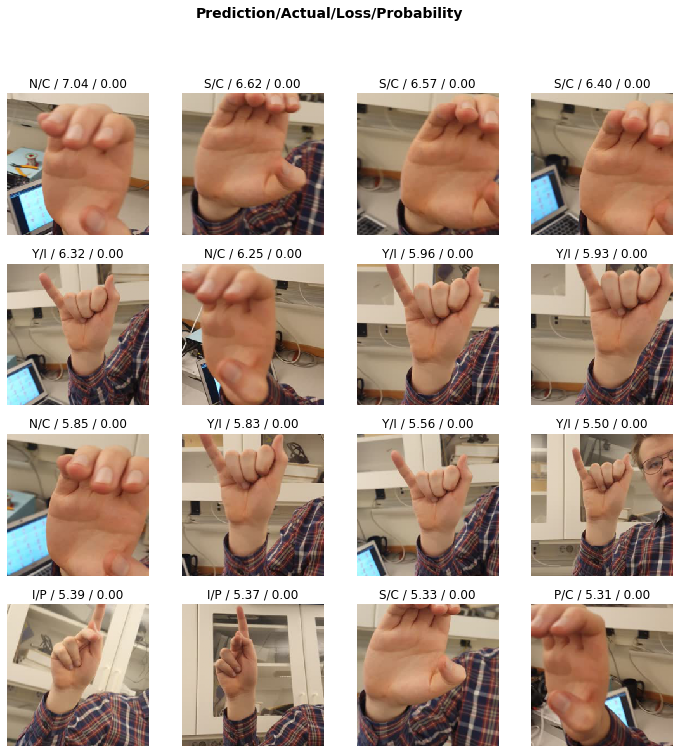

In [18]:
#interpreter.most_confused(min_val=2)
interpreter.plot_top_losses(16, figsize=(12, 12))
interpreter.most_confused(min_val=5)

In [8]:
learner.save("stage-1")
#learner.load("stage-1")
learner.unfreeze()
learner.fit_one_cycle(25, max_lr=slice(lr * .5e-2, lr), wd=0.06)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,kappa_score,time
0,0.422972,1.468371,0.657477,0.939014,0.594531,00:52
1,0.424789,1.402983,0.659983,0.934002,0.583862,00:50
2,0.433963,1.424792,0.664160,0.940685,0.591220,00:52
3,0.431772,1.345485,0.668338,0.949039,0.576313,00:47
4,0.428683,1.524645,0.651629,0.930660,0.568633,00:47
5,0.425778,1.499006,0.643275,0.933166,0.544970,00:49
6,0.382881,1.607051,0.642439,0.928989,0.532219,00:49
7,0.396623,1.469313,0.660819,0.945698,0.546194,00:52
8,0.359567,1.601686,0.652465,0.933166,0.536022,00:51
9,0.357274,1.483129,0.677527,0.948204,0.605949,00:51


In [ ]:
learner.fit_one_cycle(100, max_lr=slice(lr * .1e-5, lr * .1e-2))

In [9]:
interpreter = ClassificationInterpretation.from_learner(learner)

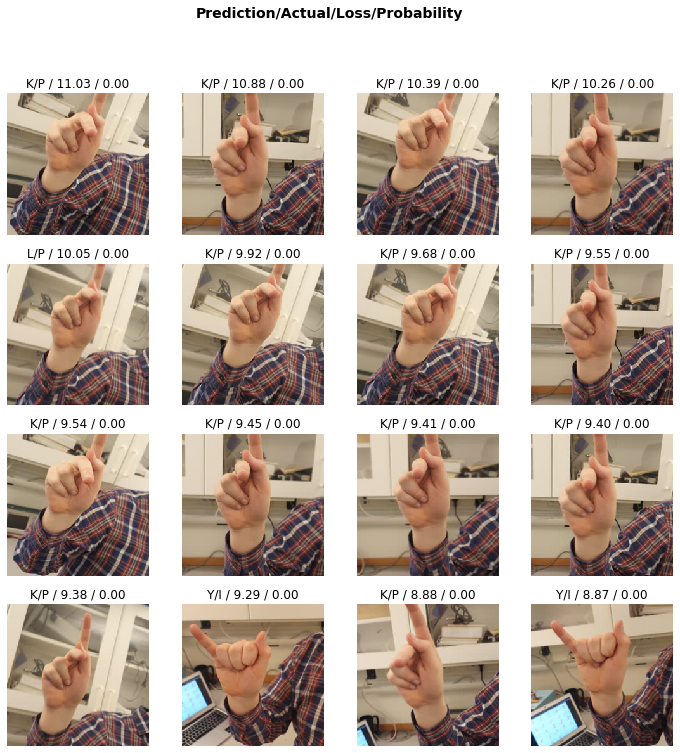

In [10]:
interpreter.plot_top_losses(16, figsize=(12, 12))

In [11]:
interpreter.most_confused(min_val=5)

[('P', 'K', 43),
 ('I', 'Y', 39),
 ('Z', 'G', 36),
 ('F', 'W', 31),
 ('T', 'N', 29),
 ('G', 'Q', 18),
 ('O', 'D', 18),
 ('G', 'Z', 15),
 ('D', 'W', 13),
 ('Z', 'Q', 13),
 ('E', 'D', 12),
 ('N', 'T', 10),
 ('O', 'E', 9),
 ('U', 'R', 8),
 ('S', 'M', 6),
 ('Z', 'P', 6),
 ('O', 'C', 5),
 ('Q', 'Z', 5)]

In [12]:
learner.save("stage-2__")
#learner.load("stage-2__")

In [13]:
import torch
import torchvision

In [15]:
learner.model

Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): ConvBNReLU(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): ConvBNReLU(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): ConvBNReLU(
            (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
            

In [16]:
model = nn.Sequential(
    learner.model.cpu(),
    nn.Softmax(1)
)
model

Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): InvertedResidual(
          (conv): Sequential(
            (0): ConvBNReLU(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU6(inplace=True)
            )
            (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
        (2): InvertedResidual(
          (conv): Sequential(
            (0): ConvBNReLU(
              (0): Conv2d(16, 

In [17]:
model = learner.model.cpu()
model.eval()

example = torch.rand(1, 3, 224, 224)
traced_script_module = torch.jit.trace(model, example)
traced_script_module.save("./android_model_2_softmax.pt")